# Training du modèle

### Import des librairies

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable


import math
import time
import os
from tqdm import tqdm

### Chargement des données

In [3]:
# open text file and read in data as `text`
passwords = []
with open('data/DATABASE_Password/Ashley-Madison.txt.out') as data_file:
    for line in data_file:
        passwords.append(str(line.replace("\n", "")))

regex_special_char = re.compile('[@_!#$%^&*()<>?/\|}{~:]')
text = "\n".join([mdp for mdp in passwords if len(mdp) >= 4 and len(mdp) <= 10 and regex_special_char.search(mdp) == None])

In [4]:
# Fonctions utilitaires pour passer d'un string à un int
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

# Readable time elapsed

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

### Définition du model

In [5]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def forward2(self, input, hidden):
        encoded = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

### Fonction permettant de générer des mdp

In [6]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=True):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))

    hidden = hidden.to(device)
    prime_input = prime_input.to(device)
    predicted = prime_str

    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        if cuda:
            inp = inp.to(device)

    return predicted


## Train

#### Paramètres du modèle

In [24]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
cuda = torch.cuda.is_available()

print("Training on: ", torch.cuda.get_device_name(0), "(", device, ")")

# Parameters
lr = 0.001
n_epochs = 1000
chunk_len = 7
batch_size = 10000
n_layers = 2
hidden_size = 256

torch.cuda.set_device(device)

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.backends.cudnn.enabled = False

Training on:  Tesla T4 ( cuda:1 )


In [8]:
# Initialisation du model
all_characters = list(set([i for i in text]))

decoder = CharRNN(
    len(all_characters),
    hidden_size,
    len(all_characters),
    model="gru",
    n_layers=n_layers
)      

In [9]:
file, file_len = text, len(text)

# Génère un batch pour train le model
def random_training_set(chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        try:
            start_index = random.randint(0, file_len - chunk_len)
            end_index = start_index + chunk_len + 1
            chunk = file[start_index:end_index]
            inp[bi] = char_tensor(chunk[:-1])
            target[bi] = char_tensor(chunk[1:])
        except:
            pass
    inp = Variable(inp)
    target = Variable(target)

    inp = inp.to(device)
    target = target.to(device)
    return inp, target

# Fonction de train
def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    
    hidden = hidden.to(device)
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()

    
    return loss.item() / chunk_len


# Save / Load le model
# Marche pas :( (le modèle semble mal se charger)
def save(model):
    save_filename = os.path.splitext(os.path.basename('gru_model_t'))[0] + '.pt'
    torch.save(model, save_filename)
    print('Saved as %s' % save_filename)

def load(PATH = None):
    if PATH == None:
        save_filename = os.path.splitext(os.path.basename('gru_model_t'))[0] + '.pt'
    else:
        save_filename = PATH

    model = CharRNN(
        len(all_characters),
        hidden_size,
        len(all_characters),
        model="gru",
        n_layers=n_layers
    )
    model = torch.load(save_filename)
    print('Loaded %s' % save_filename)
    model.to(device)
    model.eval()
    return model

In [10]:
# Fonctions permettant de clear les GPU

def pretty_size(size):
    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__, 
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
                                        type(obj.data).__name__, 
                                        " GPU" if obj.is_cuda else "",
                                        " pinned" if obj.data.is_pinned else "",
                                        " grad" if obj.requires_grad else "", 
                                        " volatile" if obj.volatile else "",
                                            pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass        
    print("Total size:", total_size)

In [91]:
# Permet de libérer le GPU
dump_tensors()
torch.cuda.empty_cache()

Parameter: GPU pinned 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768 × 256
Parameter: GPU pinned 768 × 256
Parameter: GPU pinned 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768 × 256
Parameter: GPU pinned 768 × 256
Parameter: GPU pinned 13712042 × 256
Total size: 3511072256


### Run le train
Avec les paramètres du papier :
- lr = 0.001
- n_epochs = 1000
- chunk_len = 7
- batch_size = 10000
- n_layers = 2
- hidden_size = 256

Prend une vingtaine de minutes sur un GPU Tesla T4 (16 Go)


In [25]:
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

decoder.to(device)

start = time.time()
all_losses = []
loss_avg = 0
min_loss = 9999
try:
    print("Training for %d epochs..." % n_epochs)
    for epoch in tqdm(range(1, n_epochs + 1)):
        inp, target = random_training_set(chunk_len, batch_size)
        
        loss = train(*random_training_set(chunk_len, batch_size))
        loss_avg += loss
        
        all_losses.append(loss)
        
        if epoch % 10 == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        
        if min_loss > loss:
            min_loss = loss
            save(decoder)
except KeyboardInterrupt:
    print("Saving before quit...")
    save(decoder)
    

print(time_since(start))

  0%|          | 0/1000 [00:00<?, ?it/s]

Training for 1000 epochs...


  0%|          | 1/1000 [00:02<49:11,  2.95s/it]

Saved as gru_model_t.pt


  0%|          | 2/1000 [00:06<50:13,  3.02s/it]

Saved as gru_model_t.pt


  0%|          | 3/1000 [00:08<48:19,  2.91s/it]

Saved as gru_model_t.pt


  0%|          | 4/1000 [00:10<43:15,  2.61s/it]

Saved as gru_model_t.pt


  0%|          | 4/1000 [00:13<54:08,  3.26s/it]

Saving before quit...
Saved as gru_model_t.pt
0m 13s


### Permet de print la loss

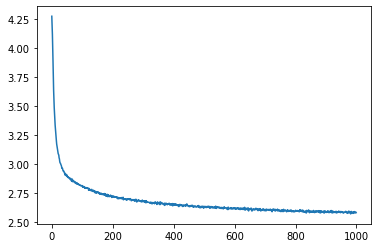

In [11]:
from matplotlib import pyplot as plt

plt.plot(all_losses)
plt.savefig('loss_gru.png')

### Génération des mots de passes
Le nombre de mdp générés dépend du:
- Nombre de seeds utilisées
- Nombre de caractères générés pour chaque seed

Soit environ:
$\frac{Nb\_seed * Nb\_char}{\bar{x}}$

Où $\bar{x}$ est la taille moyenne des mots de passes dans le corpus de train

$\bar{x} = 7$

La génération prend 5 heures pour $Nb\_seeds = 10000$ et $Nb\_char = 2500$. Soit environ 0,006 secondes par mot de passe généré

Cependant il y a environ 1 mot de passe sur 3 qui est un doublon. Cela peut être diminué par la température de la génération, au risque d'avoir des mots de passes incohérents.

In [12]:
from collections import Counter

# Permet de générer une seed de caractère pondéré sur le nombre d'apparition
counter_text = Counter(text.replace("\n", ""))
all_char = [i for i in counter_text]
all_char_prob = [counter_text[i] for i in counter_text]

nb_seed = 100
nb_char = 250

generated = []
start_time = time.time()

one_seed_chars = random.choices(all_char, weights=all_char_prob, k=10000)
i = 0
for char in one_seed_chars:
    i += 1
    generated.extend(generate(decoder, char, 2500, temperature = 0.6, cuda=True).split("\n"))
    if i % nb_seed == 0:
        print(i)

time_since(start_time)


with open("generated_pwd.txt", "w") as output:
    for pwd in generated:
        output.write(pwd + "\n")

print(len([len(i) for i in generated]))

KeyboardInterrupt: 

In [ ]:
print(generated[len(generated)-100:])

## Affichage des résultats

In [51]:
print("all generated : ", len(generated))
print("uniq generated: ", len(set(generated)))
generated_uniq = list(set(generated))
cpt = 0
cracked = []
with open("data/" + "hak_2352_clear.txt") as f:
    for line in f.readlines():
        for i in generated_uniq:
            if i.strip() == line.strip():
                cpt += 1
                cracked.append(line)
print("nombre cracked:", cpt, "/", len(generated_uniq))

all generated :  1924
uniq generated:  1866
nombre cracked: 1 / 1866


In [50]:
all_generated = []
nb_cracked = []
all_cracked = []
start_time = time.time()

for i in range (1, 21, 5):
    one_seed_chars = [random.choices(all_char, weights=all_char_prob, k=i)][0]
    generated = []
    for char in one_seed_chars:
        generated.extend(generate(decoder, char, 1000, temperature = 0.5, cuda=True).split("\n"))
    
    all_generated.append(generated)
    cpt = 0
    generated_uniq = list(set(generated))
    
    with open("data/" + "hak_2352_clear.txt") as f:
        for line in f.readlines():
            for i in generated_uniq:
                if i.strip() == line.strip():
                    cpt += 1
                    cracked.append(line)
        all_cracked.append(cracked)
    nb_cracked.append(cpt)
time_since(start_time)

In [99]:
print(nb_cracked)
print(sum([len(i) for i in all_generated]))

[0, 3, 0, 7, 6, 5, 6, 6, 7, 7, 8, 13, 11, 14, 12, 11, 14, 10, 12, 17, 17, 13, 14, 18, 12, 10, 11, 15, 16, 14, 12, 15, 23, 16, 21, 22, 26, 23, 16, 26, 22, 24, 19, 26, 22, 23, 20, 25, 18, 26, 24, 22, 18, 26, 26, 24, 24, 19, 22, 25, 30, 29, 29, 28, 29, 25, 26, 23, 28, 27, 27, 28, 26, 29, 28, 26, 25, 32, 27, 24, 26, 31, 31, 31, 31, 33, 29, 38, 31, 29, 31, 35, 33, 35, 30, 32, 26, 32, 39, 30]
3311602


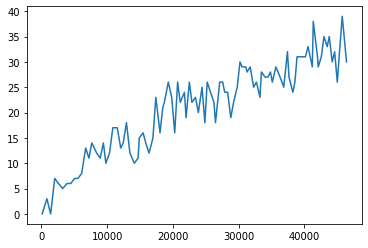

In [98]:
all_generated_sum = []
for lst_gen in all_generated:
    for gen in lst_gen:
    all_generated_uniq.append(set(l))

plt.plot([len(i) for i in all_generated_uniq], nb_cracked)
plt.savefig('pwd_cracked_by_generated.png')

### Approche probabiliste

In [ ]:
print(cracked[:100])

In [12]:
from collections import Counter
counter_text = Counter(text.replace("\n", ""))
all_char = [i for i in counter_text]
all_char_prob = [counter_text[i] for i in counter_text]

tot_char = sum(all_char_prob)
all_char_prob = [i/tot_char for i in all_char_prob]


lst_pwd = []
for _ in range(500000):
    pwd_size = random.choice([6,7,8])
    pwd = ""
    for i in range(pwd_size):
        pwd += [random.choices(all_char, weights=all_char_prob, k=1)][0][0]
    lst_pwd.append(pwd)

In [ ]:
print(lst_pwd[:100])
cpt = 0
cracked = []
with open("data/DATABASE_Password/" + "hak_2352_clear.txt") as f:
    for line in f.readlines():    
        for i in lst_pwd:
            if i.strip() == line.strip():
                cpt += 1
                cracked.append(line)
print("nombre cracked:", cpt, "/", len(lst_pwd))

### Plot des résultats

In [13]:
a_g = []
with open("generated_pwd.txt") as f:
    for l in f.readlines():
         a_g.append(l)
print(len(a_g))
print(len(set(a_g)))

cpt = 0
cracked = []
a_g_s = set(a_g[:int(len(a_g)/2)])
hak_2352 = []
with open("data/DATABASE_Password/" + "hak_2352_clear.txt") as f:
        for line in f.readlines():
            hak_2352.append(line)
print(len(hak_2352))
same = set(hak_2352).intersection(a_g_s)

print(len(same))

3436210
1284766
2335
146


In [35]:
it = []
sames = []
s_hak2352 = set(hak_2352)
a_g_s = set(a_g)
a_g_l = list(a_g_s)
for i in range (0, len(a_g_l), 50):
    a_g_s = set(a_g_l[:i])
    same = s_hak2352.intersection(a_g_s)

    it.append(i)
    sames.append(len(same))
    if i % 5000 == 0:
        print(i)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000
265000
270000
275000
280000
285000
290000
295000
300000
305000
310000
315000
320000
325000
330000
335000
340000
345000
350000
355000
360000
365000
370000
375000
380000
385000
390000
395000
400000
405000
410000
415000
420000
425000
430000
435000
440000
445000
450000
455000
460000
465000
470000
475000
480000
485000
490000
495000
500000
505000
510000
515000
520000
525000
530000
535000
540000
545000
550000
555000
560000
565000
570000
575000
580000
585000
590000
595000
600000
605000
610000
615000
620000
625000
630000
635000
640000
645000
650000
655000
660000
665000
670000
675000
680000
685000
690000
695000
700000
705000
710000
715000
720000
725000
730

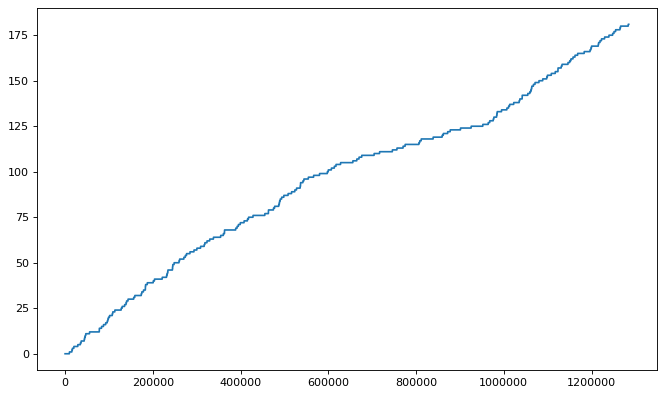

In [44]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

plt.ticklabel_format(style = 'plain')
plt.plot(it, sames)
plt.savefig("resultats")